In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Load and Combine the dataset
!cat "ECG5000_TRAIN.txt" "ECG5000_TEST.txt" > ecg_final.txt
df = pd.read_csv("ecg_final.txt", sep='  ', header=None)

df.head()

<ipython-input-6-5ed4a34550af>:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv("ecg_final.txt", sep='  ', header=None)


,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,1.0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,...,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137
1,1.0,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,...,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250
2,1.0,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,...,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797
3,1.0,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,...,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564
4,1.0,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,...,0.966606,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456


In [ ]:
# Train-Test Splitting and Scaling
x_train, x_test, y_train, y_test = train_test_split(df.values, df.values[:,0:1], test_size=0.2, random_state=111)
scaler = MinMaxScaler()
data_scaled = scaler.fit(x_train)
train_data_scaled = data_scaled.transform(x_train)
test_data_scaled = data_scaled.transform(x_test)

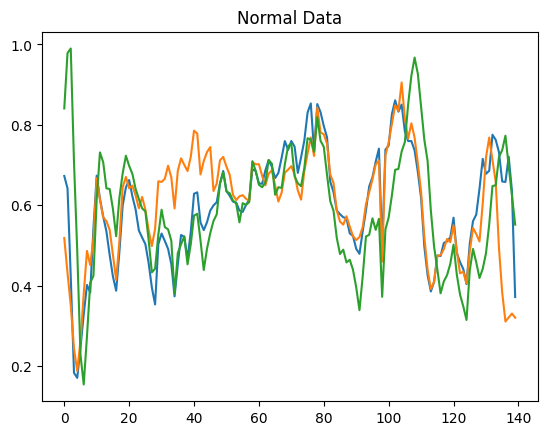

In [ ]:
# Separate Anomaly and Normal Data
normal_train_data = pd.DataFrame(train_data_scaled).add_prefix('c').query('c0 == 0').values[:,1:]
anomaly_train_data = pd.DataFrame(train_data_scaled).add_prefix('c').query('c0 > 0').values[:, 1:]
normal_test_data = pd.DataFrame(test_data_scaled).add_prefix('c').query('c0 == 0').values[:,1:]
anomaly_test_data = pd.DataFrame(test_data_scaled).add_prefix('c').query('c0 > 0').values[:, 1:]

# Data Visualization
plt.plot(normal_train_data[0])
plt.plot(normal_train_data[1])
plt.plot(normal_train_data[2])
plt.title("Normal Data")
plt.show()

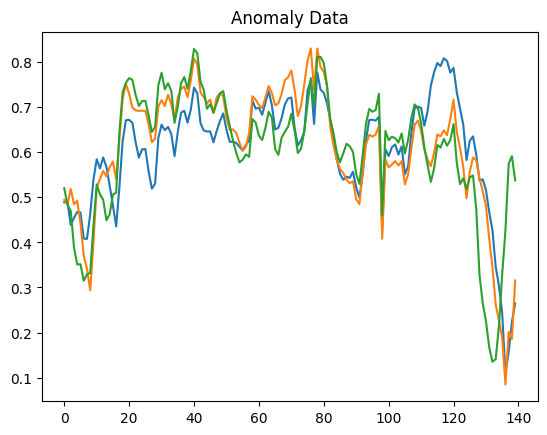

In [ ]:
plt.plot(anomaly_train_data[0])
plt.plot(anomaly_train_data[1])
plt.plot(anomaly_train_data[2])
plt.title("Anomaly Data")
plt.show()

In [ ]:
# Modelling
class AutoEncoder(Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = tf.keras.Sequential([
                        tf.keras.layers.Dense(64, activation="relu"),
                        tf.keras.layers.Dense(32, activation="relu"),
                        tf.keras.layers.Dense(16, activation="relu"),
                        tf.keras.layers.Dense(8, activation="relu")
                    ])
        self.decoder = tf.keras.Sequential([
                        tf.keras.layers.Dense(16, activation="relu"),
                        tf.keras.layers.Dense(32, activation="relu"),
                        tf.keras.layers.Dense(64, activation="relu"),
                        tf.keras.layers.Dense(140, activation="sigmoid")
                    ])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Compile and train the Model
model = AutoEncoder()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, mode="min")
model.compile(optimizer='adam', loss="mae")
history = model.fit(normal_train_data, normal_train_data, epochs=50, batch_size=120,
                    validation_data=(train_data_scaled[:,1:], train_data_scaled[:, 1:]),
                    shuffle=True,
                    callbacks=[early_stopping]
                    )


Epoch 1/50
20/20 [==============================] - 2s 19ms/step - loss: 0.1216 - val_loss: nan
Epoch 2/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0753 - val_loss: nan


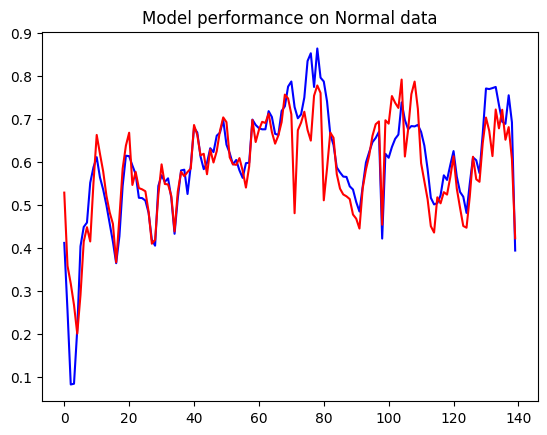

In [ ]:

# Model Evaluation
encoder_out = model.encoder(normal_test_data).numpy()
decoder_out = model.decoder(encoder_out).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoder_out[0], 'r')
plt.title("Model performance on Normal data")
plt.show()


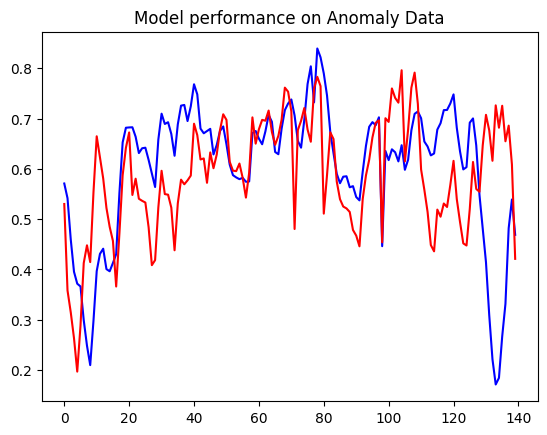

In [ ]:
encoder_out_a = model.encoder(anomaly_test_data).numpy()
decoder_out_a = model.decoder(encoder_out_a).numpy()
plt.plot(anomaly_test_data[0], 'b')
plt.plot(decoder_out_a[0], 'r')
plt.title("Model performance on Anomaly Data")
plt.show()

19/19 [==============================] - 0s 2ms/step


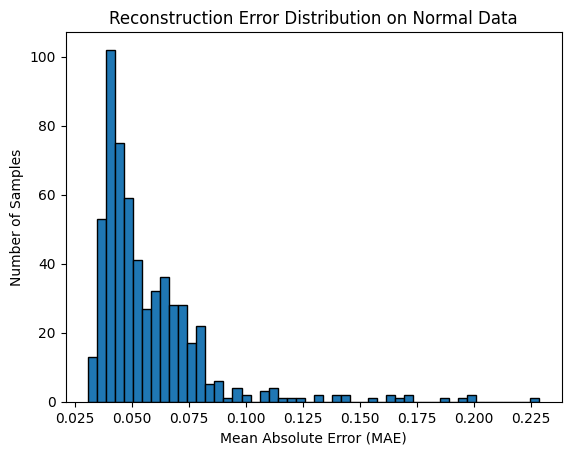

In [ ]:
# Calculate Loss
reconstruction = model.predict(normal_test_data)
train_loss = tf.keras.losses.mae(reconstruction, normal_test_data)

# Plotting Histogram
plt.hist(train_loss, bins=50, edgecolor='black')
plt.xlabel('Mean Absolute Error (MAE)')
plt.ylabel('Number of Samples')
plt.title('Reconstruction Error Distribution on Normal Data')
plt.show()

9/9 [==============================] - 0s 3ms/step


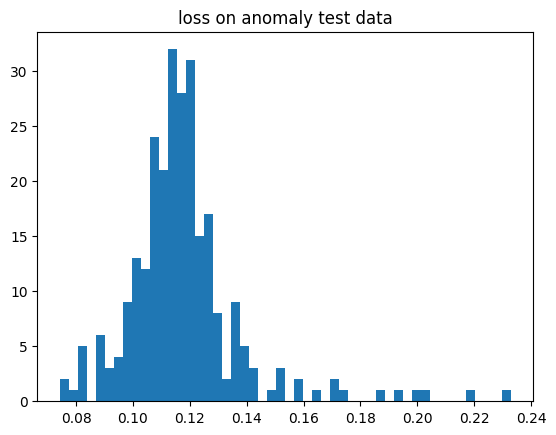

In [ ]:
threshold = np.mean(train_loss) + 2*np.std(train_loss)
reconstruction_a = model.predict(anomaly_test_data)
train_loss_a = tf.keras.losses.mae(reconstruction_a, anomaly_test_data)
plt.hist(train_loss_a, bins=50)
plt.title("loss on anomaly test data")
plt.show()

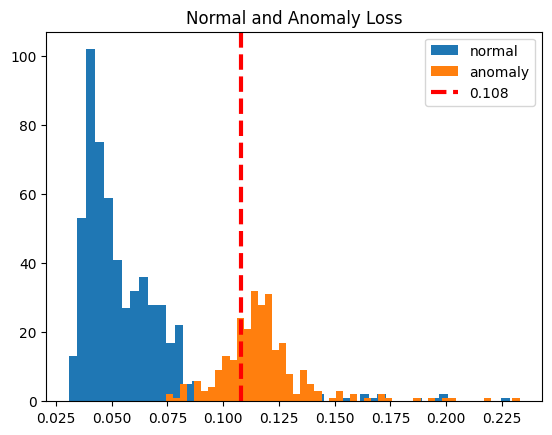

In [ ]:
plt.hist(train_loss, bins=50, label='normal')
plt.hist(train_loss_a, bins=50, label='anomaly')
plt.axvline(threshold, color='r', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold))
plt.legend(loc='upper right')
plt.title("Normal and Anomaly Loss")
plt.show()

In [ ]:
preds_a = tf.math.greater(train_loss_a, threshold)
tf.math.count_nonzero(preds_a)

<tf.Tensor: shape=(), dtype=int64, numpy=195>